In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ROCAUC

pd.options.display.max_columns = 100

%matplotlib inline

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [3]:
train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [8]:
# Do not re-run this. It takes super long..
report = train.profile_report()
report.to_file('train-data-profile.html')

# Feature Engineering

In [4]:
# Convert bin_3 and bin_4 into integer
train['bin_3'] = train['bin_3'].replace({"T":1, "F":0})
train['bin_4'] = train['bin_4'].replace({"Y":1, "N":0})

In [5]:
# Cyclical encode day and month
train['day_sin'] = np.sin(2*np.pi*(train['day'] / 7))
train['day_cos'] = np.cos(2*np.pi*(train['day'] / 7))

train['month_sin'] = np.sin(2*np.pi*(train['month'] / 12))
train['month_cos'] = np.cos(2*np.pi*(train['month'] / 12))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


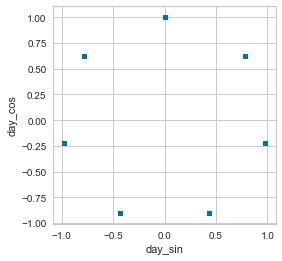

In [6]:
train.plot.scatter('day_sin', 'day_cos').set_aspect('equal')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


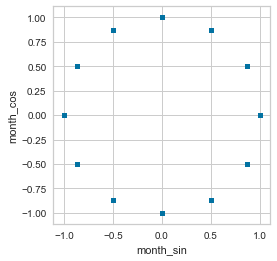

In [7]:
train.plot.scatter('month_sin', 'month_cos').set_aspect('equal')

In [8]:
# create label encoders for features with no obvious ranks
# TODO: One hot encoding and PCA

# fit
nom_0_encoder = LabelEncoder().fit(train['nom_0'])
nom_1_encoder = LabelEncoder().fit(train['nom_1'])
nom_2_encoder = LabelEncoder().fit(train['nom_2'])
nom_3_encoder = LabelEncoder().fit(train['nom_3'])
nom_4_encoder = LabelEncoder().fit(train['nom_4'])
nom_5_encoder = LabelEncoder().fit(train['nom_5'])
nom_6_encoder = LabelEncoder().fit(train['nom_6'])
nom_7_encoder = LabelEncoder().fit(train['nom_7'])
nom_8_encoder = LabelEncoder().fit(train['nom_8'])
nom_9_encoder = LabelEncoder().fit(train['nom_9'])

# transform
train['nom_0'] = nom_0_encoder.transform(train['nom_0'])
train['nom_1'] = nom_1_encoder.transform(train['nom_1'])
train['nom_2'] = nom_2_encoder.transform(train['nom_2'])
train['nom_3'] = nom_3_encoder.transform(train['nom_3'])
train['nom_4'] = nom_4_encoder.transform(train['nom_4'])
train['nom_5'] = nom_5_encoder.transform(train['nom_5'])
train['nom_6'] = nom_6_encoder.transform(train['nom_6'])
train['nom_7'] = nom_7_encoder.transform(train['nom_7'])
train['nom_8'] = nom_8_encoder.transform(train['nom_8'])
train['nom_9'] = nom_9_encoder.transform(train['nom_9'])

In [9]:
# process ordinal features according to their ranks
train['ord_1'] = train['ord_1'].replace({"Novice":0, 
                                         "Contributor": 1,
                                         "Expert": 2,
                                         "Master": 3,
                                         "Grandmaster": 4})

In [10]:
train['ord_2'] = train['ord_2'].replace({"Freezing":0, 
                                         "Cold": 1,
                                         "Warm": 2,
                                         "Hot": 3,
                                         "Boiling Hot": 4,
                                         "Lava Hot": 5})

In [11]:
# create lexical orders
ord_3_order = sorted(train['ord_3'].unique().tolist())
ord_4_order = sorted(train['ord_4'].unique().tolist())
ord_5_order = sorted(train['ord_5'].unique().tolist())

# fit encoders
ord_3_encoder = LabelEncoder().fit(ord_3_order)
ord_4_encoder = LabelEncoder().fit(ord_4_order)
ord_5_encoder = LabelEncoder().fit(ord_5_order)

# transform
train['ord_3'] = ord_3_encoder.transform(train['ord_3'])
train['ord_4'] = ord_4_encoder.transform(train['ord_4'])
train['ord_5'] = ord_5_encoder.transform(train['ord_5'])

In [12]:
# remove useless columns
train = train.drop(['id', 'day', 'month'], axis=1)

In [13]:
# normalisation
y = train['target']
cyc_features = train[['day_sin', 'day_cos', 'month_sin', 'month_cos']]
X = train.drop(['target', 'day_sin', 'day_cos', 'month_sin', 'month_cos'], axis=1)
X_col = X.columns

normaliser = MinMaxScaler().fit(X)
X = normaliser.transform(X)
X = pd.DataFrame(X, columns=X_col)
X = pd.concat([X, cyc_features], axis=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [14]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
# modeling
lr_model = LogisticRegression().fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


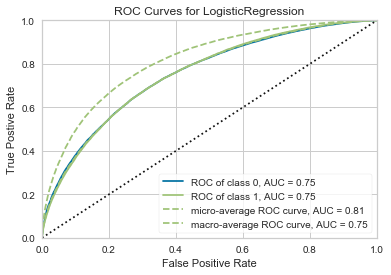

In [17]:
# evaluation
visualizer = ROCAUC(lr_model, classes=["0", "1"])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()  